# CPO Notebook (with many assets)

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import time
import missingno
import optuna
import pandas_ta as ta

c:\Users\alber\python_projects\IP_AI_project\IP_AI_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters and data loading

,EQ CHINA,SX5E,SPX,EQ LAT,EQ PEXJP,EQ CHINA_rsi,EQ CHINA_roc,EQ CHINA_mom,EQ CHINA_ema50,EQ CHINA_ema200,...,S&P 500 INDUSTRIA,S&P 500 CONS STAPL,S&P 500 COMM,S&P 500 REAL ESTA,RF_US,RF_EU,US_EPS,SXXE,EU_EPS,Govies Euro Volatility
date,,,,,,,,,,,,,,,,,,,,,
2005-04-26,0.009982,-0.001282,-0.008915,0.009045,0.000919,54.144855,-363.036045,0.013777,0.000284,0.000659,...,-0.012080,-0.006843,-0.006514,-0.002906,0.004238,-0.000290,-0.000013,-0.002048,0.000000,-0.000289
2005-04-27,-0.005465,-0.013609,0.004029,-0.010156,-0.001801,47.306049,-175.828771,-0.012671,0.000059,0.000598,...,0.003176,0.004664,0.018116,0.008488,-0.009777,-0.010438,0.000000,-0.014546,0.000000,0.002387
2005-04-28,0.002415,-0.003993,-0.011380,-0.026060,0.001447,50.826219,-126.932436,0.011381,0.000151,0.000616,...,-0.013099,-0.004898,-0.005253,-0.011137,-0.018706,-0.004395,0.000000,-0.004499,0.000000,0.000894
2005-05-12,-0.001012,0.007605,-0.010033,-0.014054,-0.002471,49.080036,-141.891712,-0.003426,0.000331,0.000633,...,-0.011994,-0.005234,-0.004227,-0.012215,-0.007544,0.002408,-0.000877,0.006360,0.002015,-0.000474
2005-05-13,-0.011307,0.000478,-0.004580,-0.008143,-0.009447,43.626198,145.338407,-0.006698,-0.000125,0.000514,...,-0.005578,-0.007745,-0.006151,-0.014674,-0.012709,-0.006907,0.002085,0.000511,0.000000,0.001919


<Axes: >

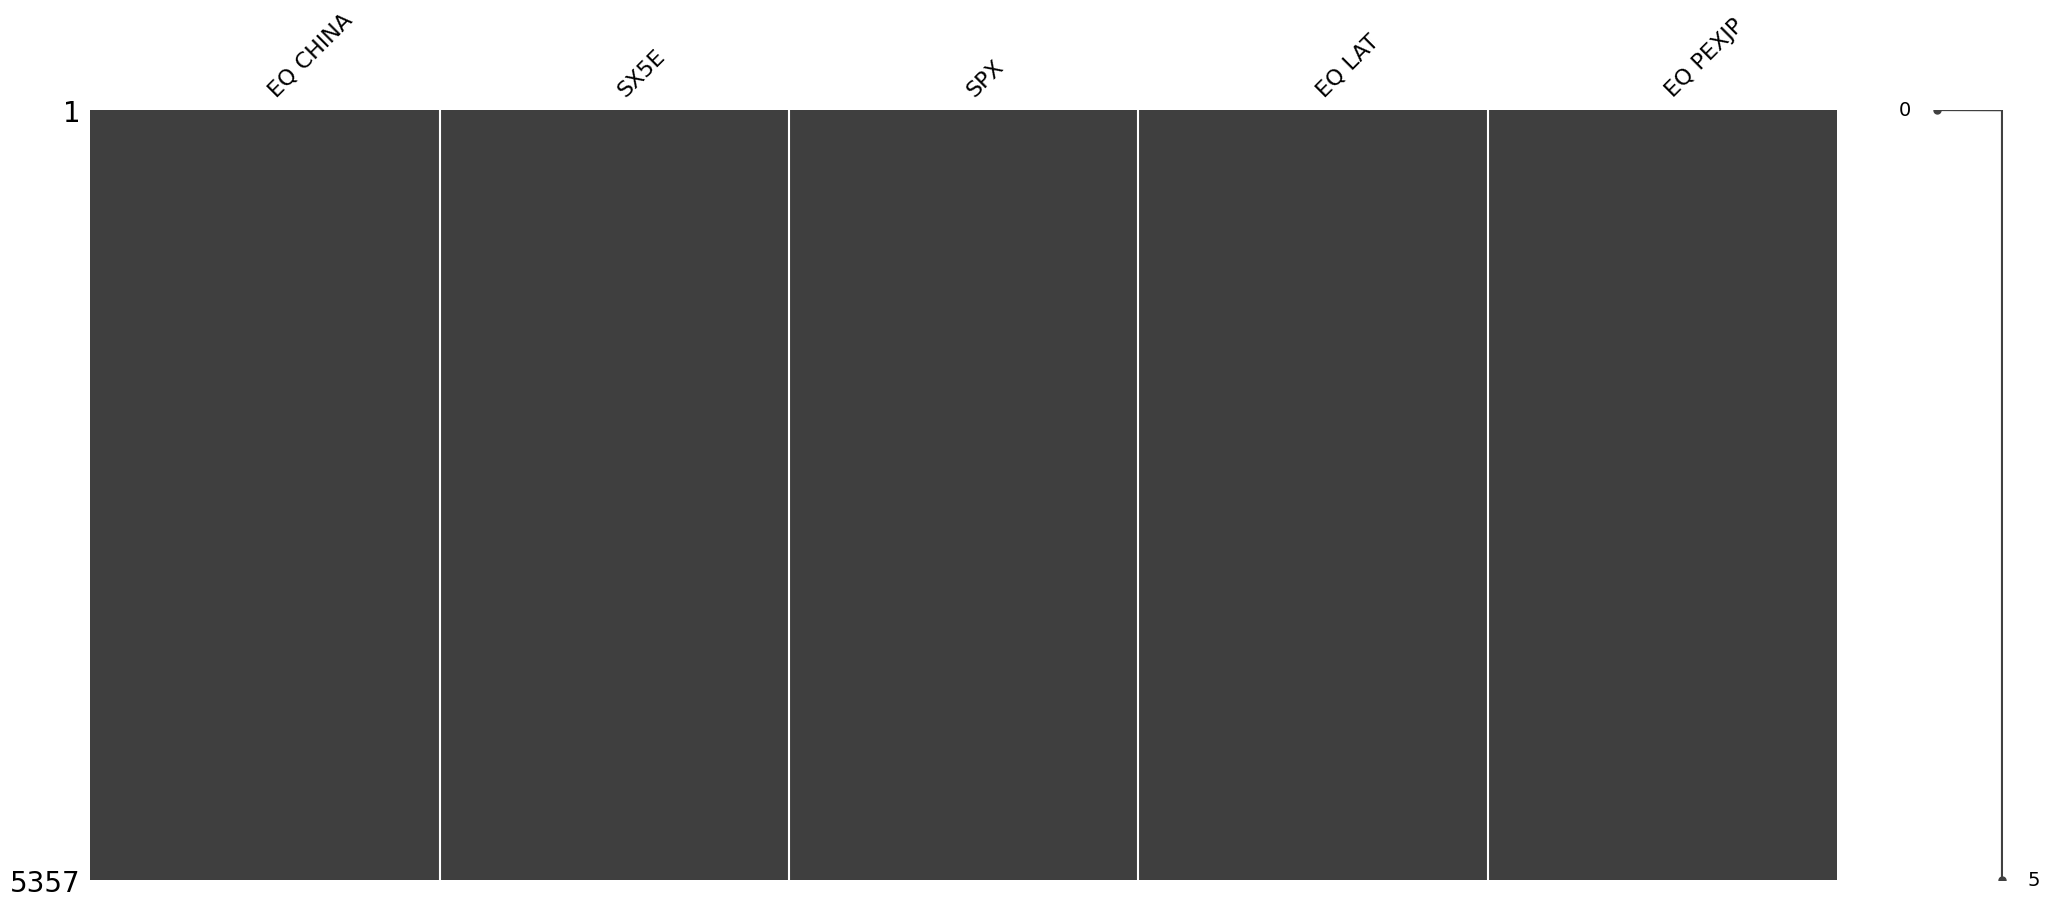

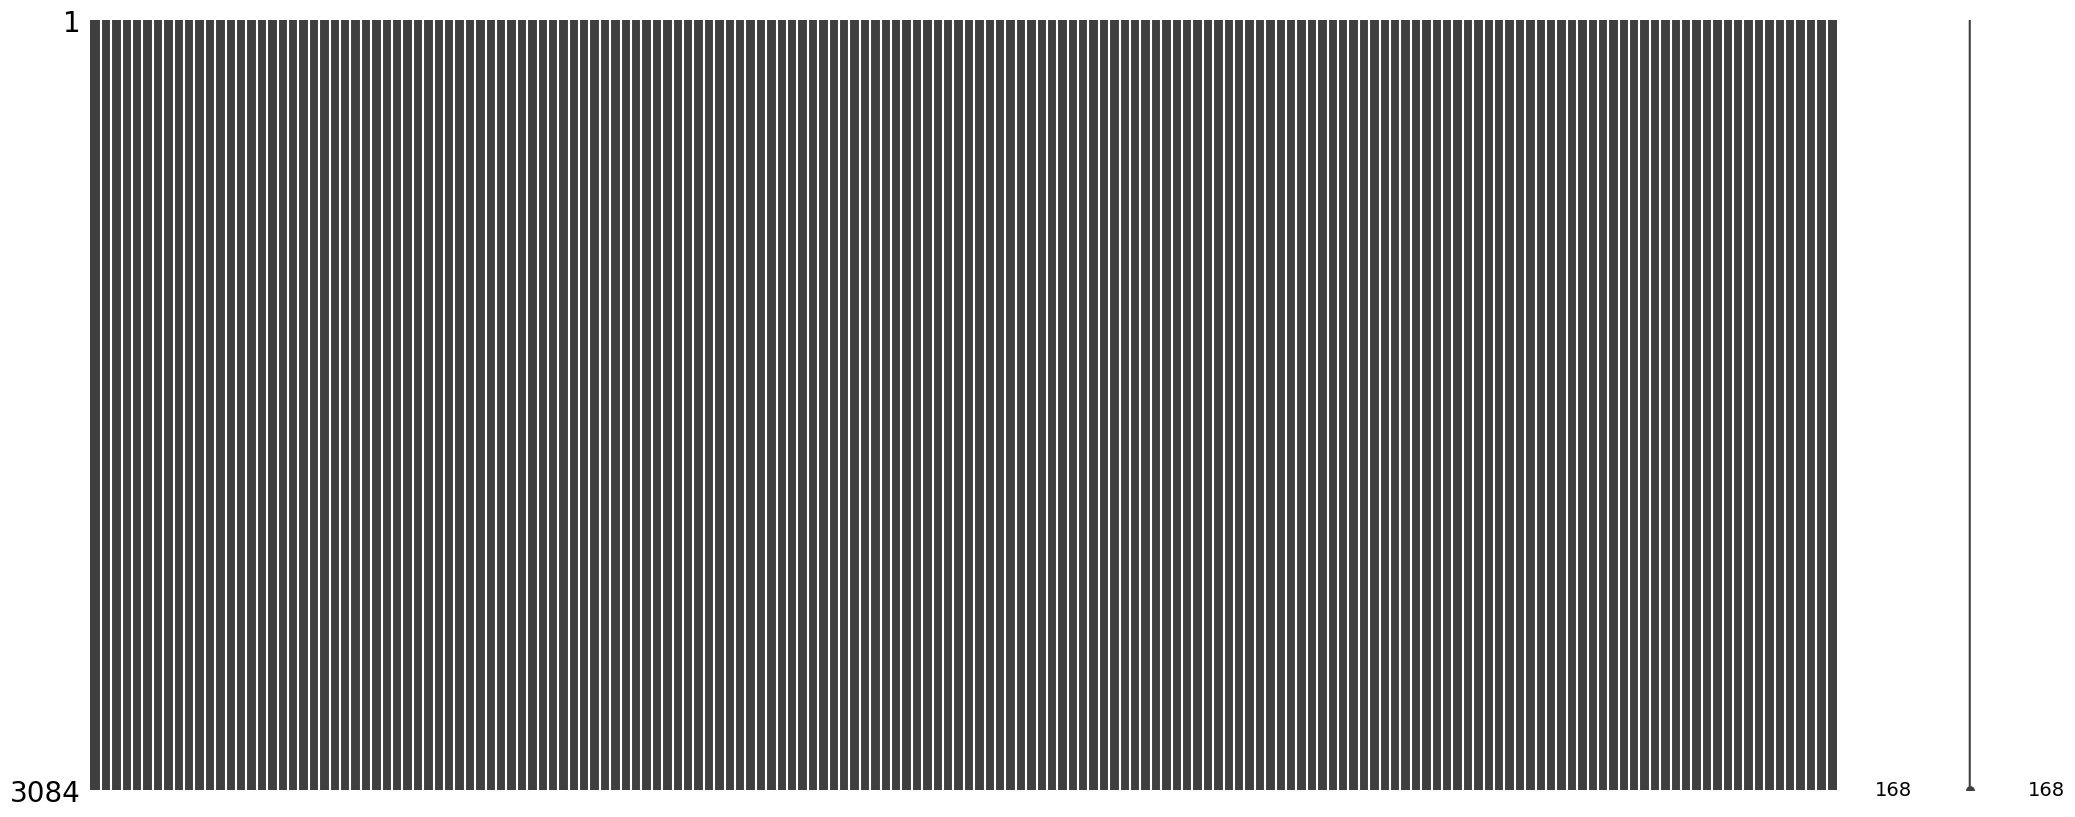

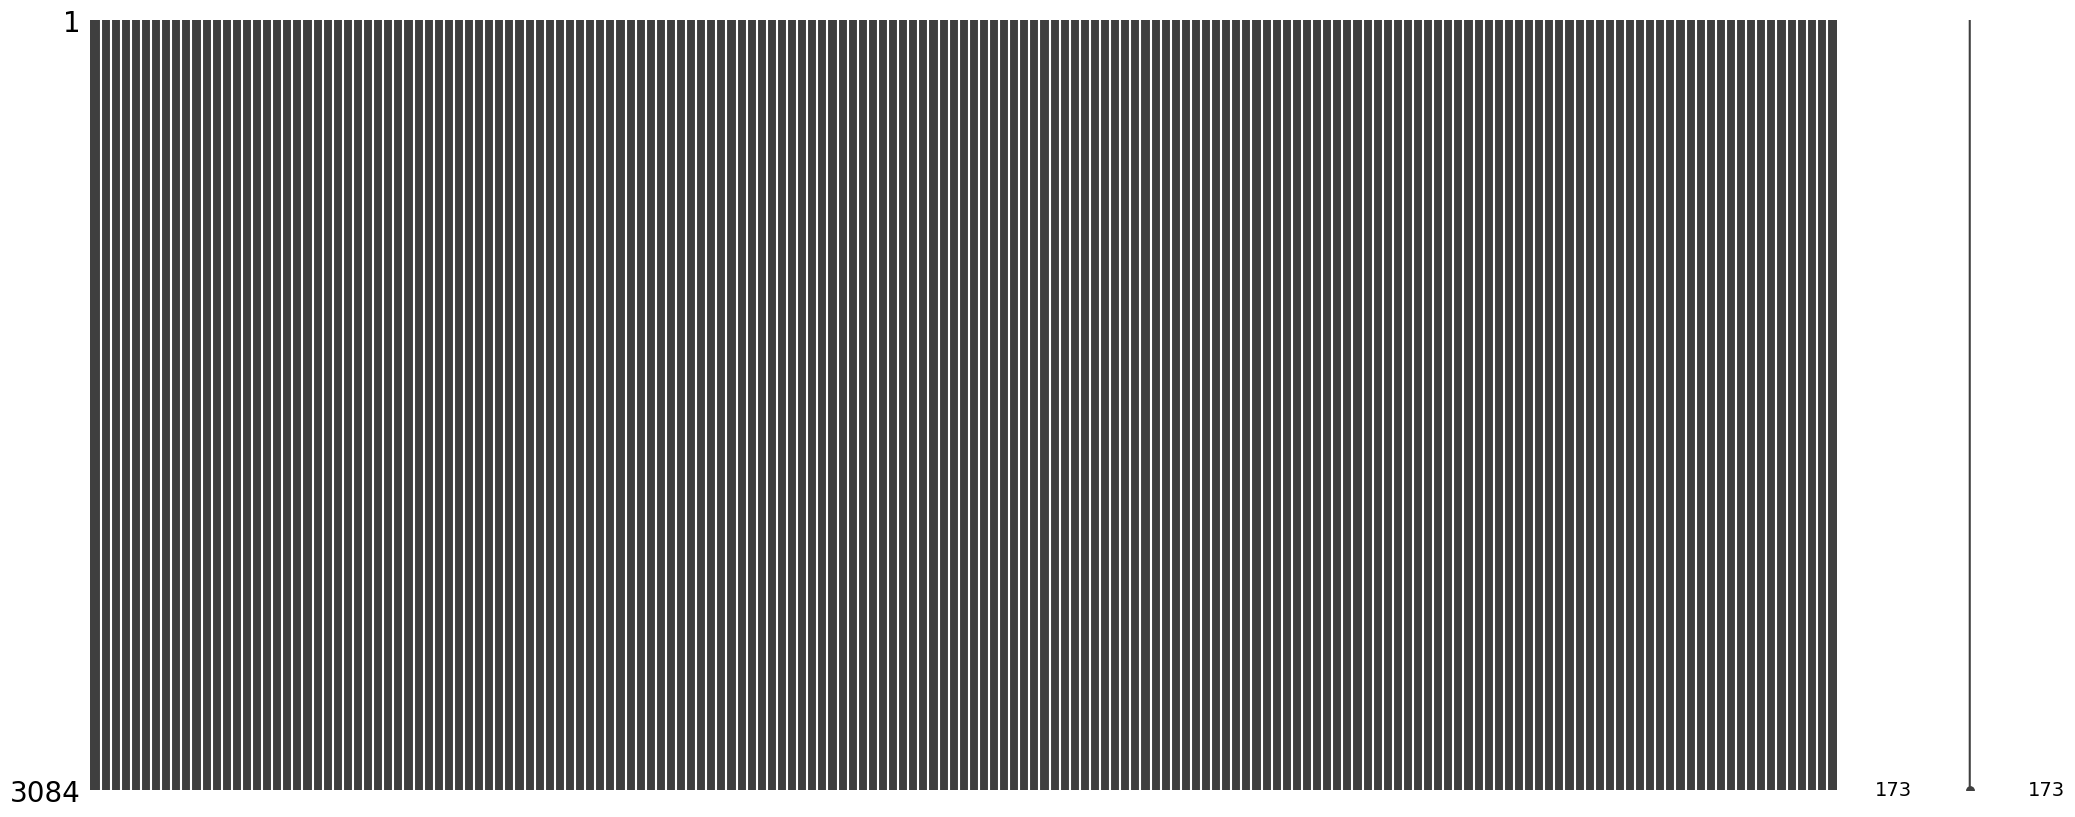

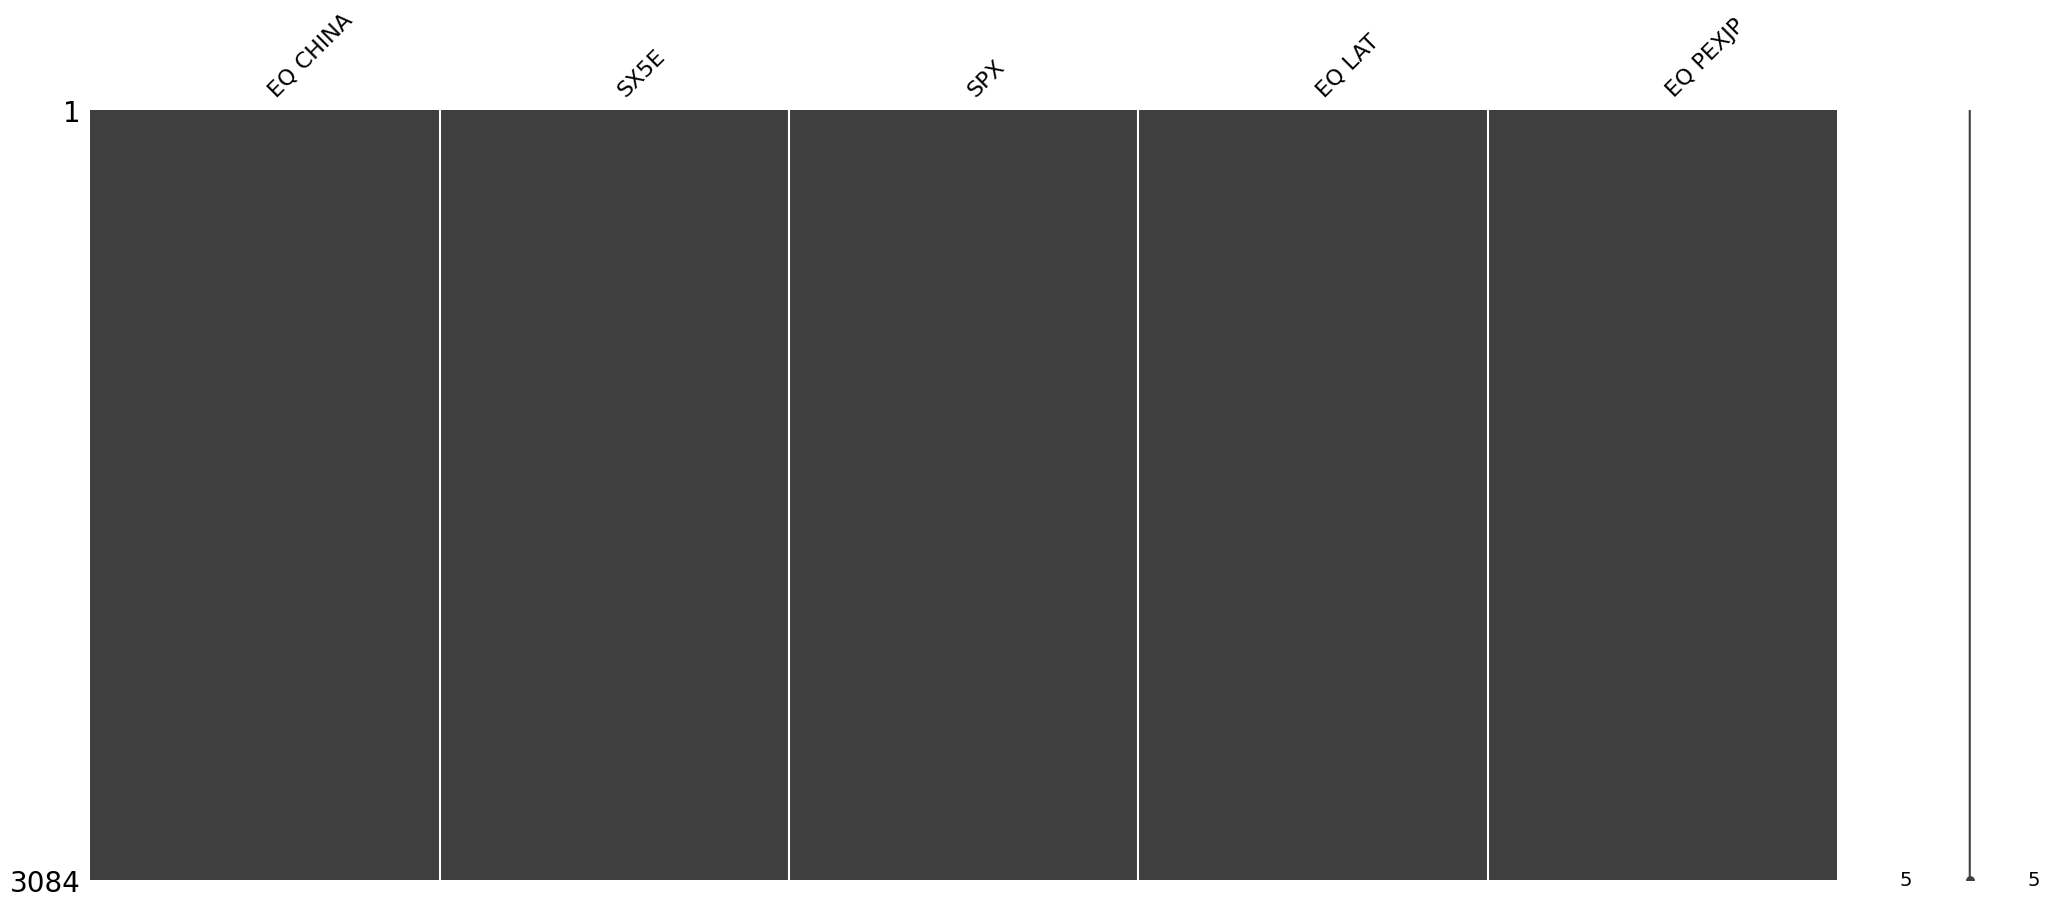

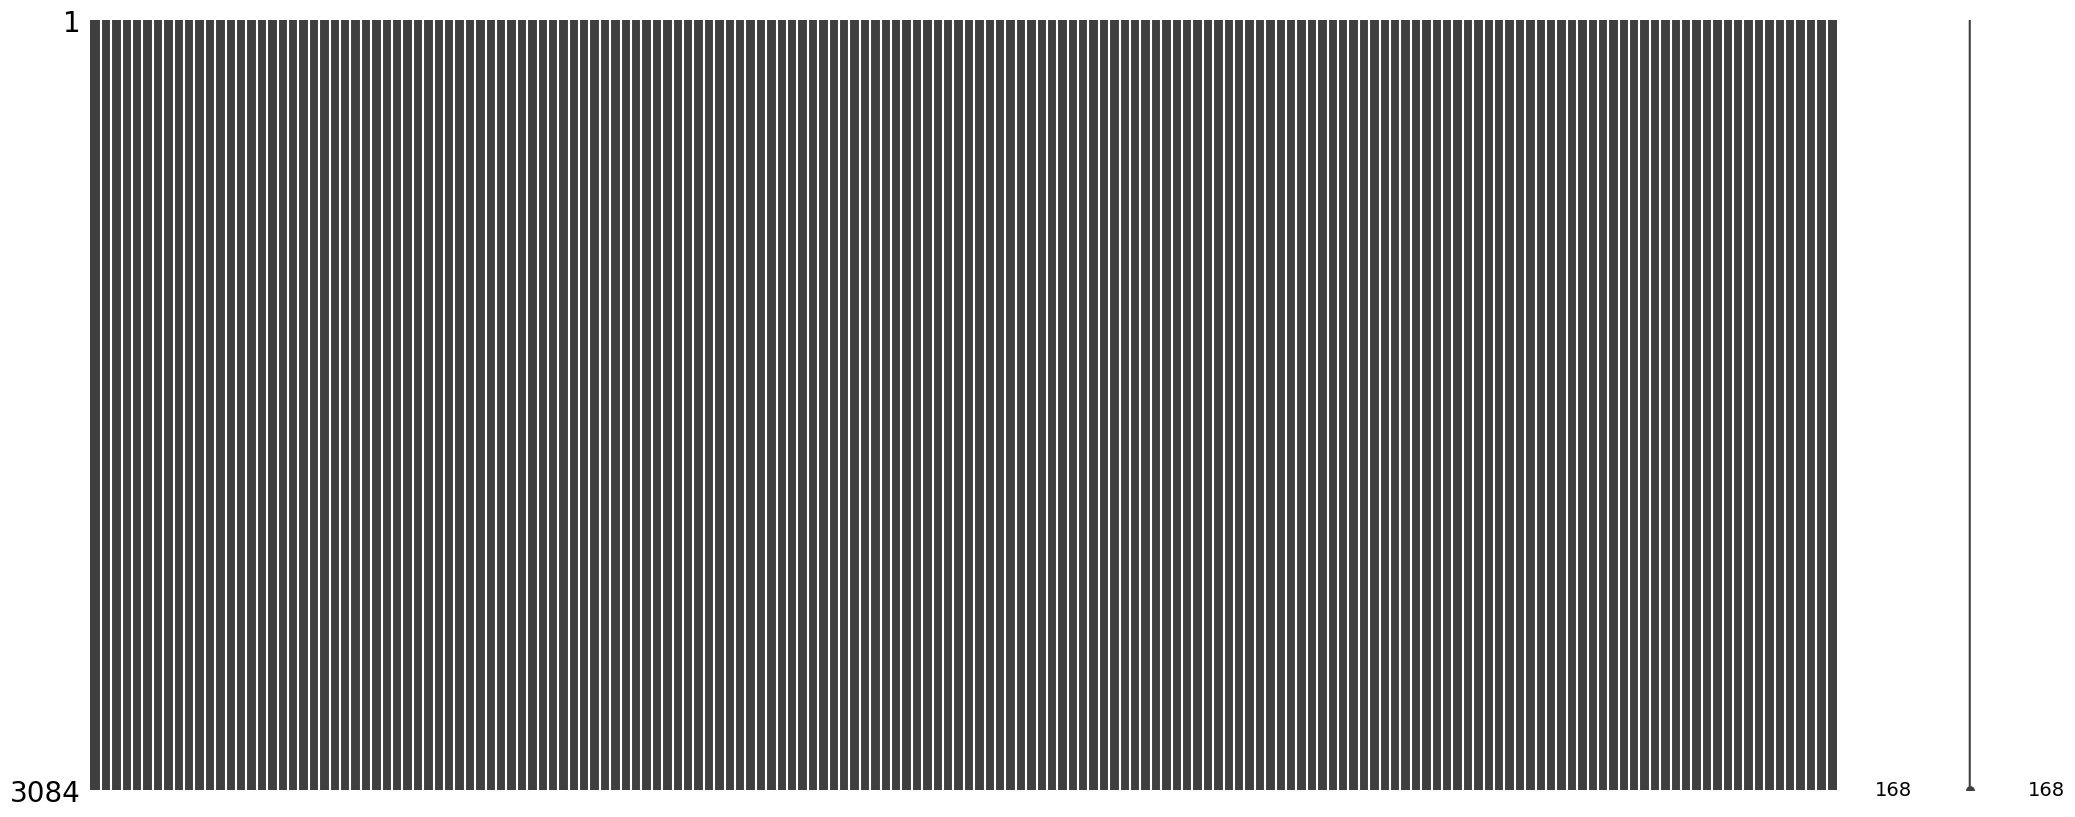

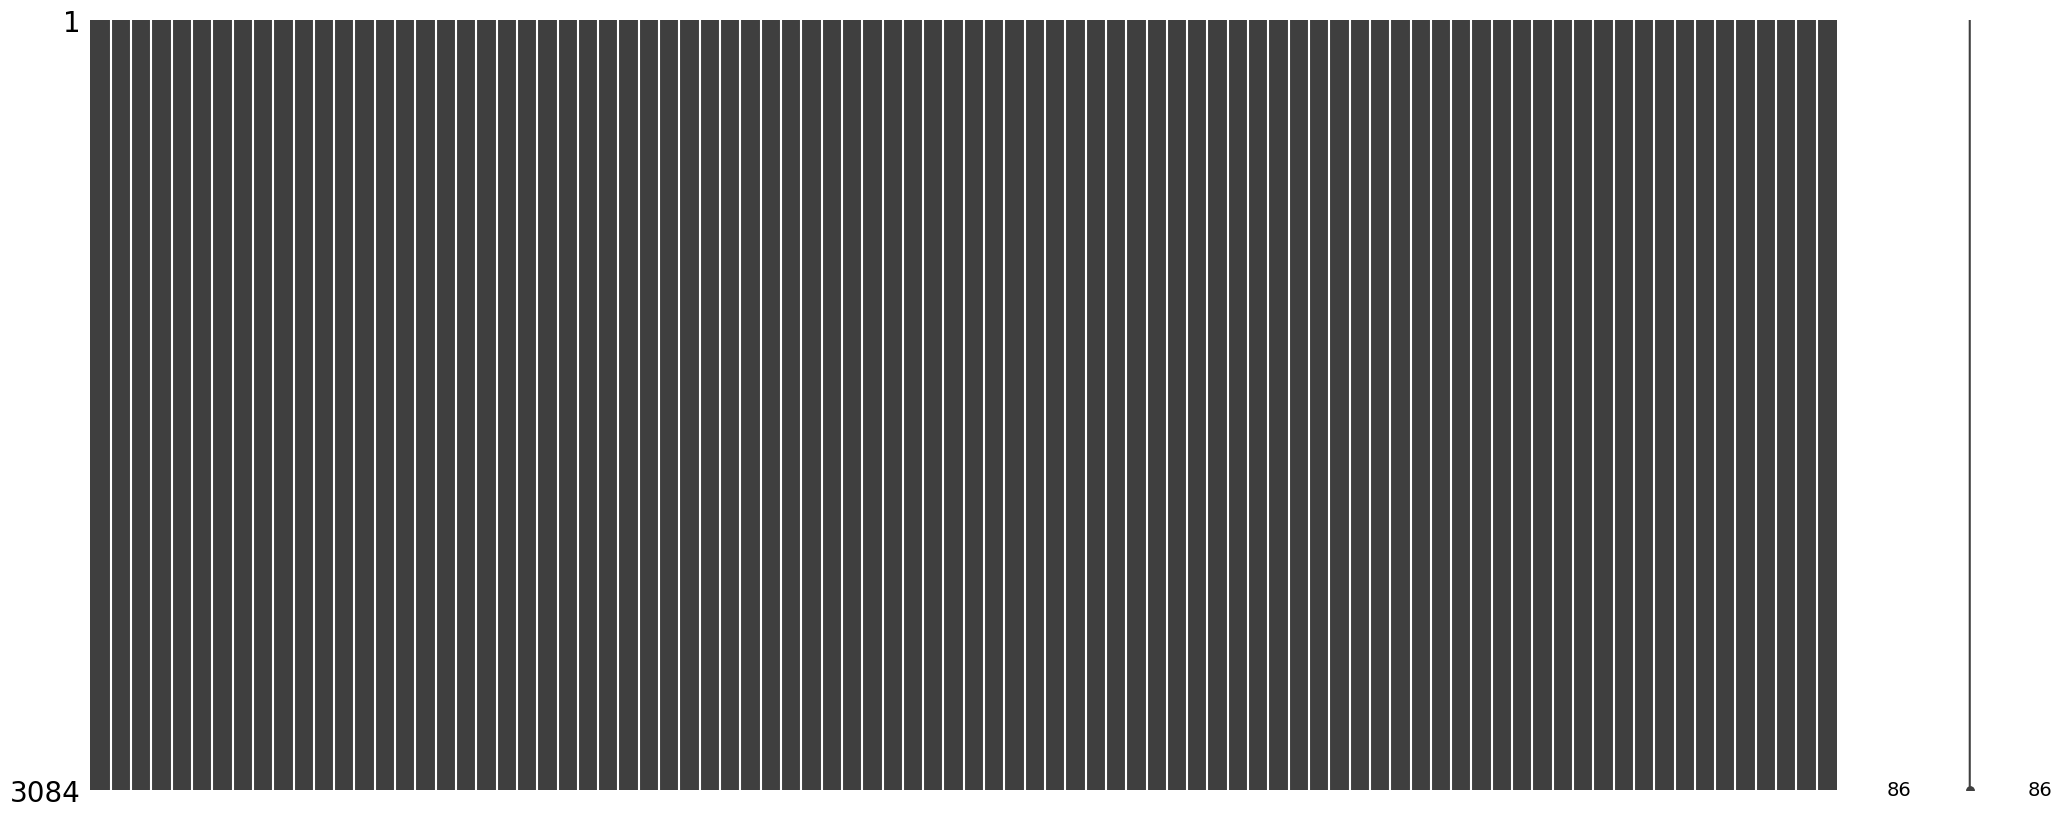

In [22]:
n_assets = 5
N = 50  # combinations
rnd_seed = 42
date_start = '2004-07-21'

# Select metric for evaluation 1\2\3 (r2\mse\mae)
metric_choice = '3' # Must be in ' '



asset_returns = pd.read_csv('asset_returns.csv')
features = pd.read_csv('features.csv')

asset_returns = asset_returns.set_index("date")
features = features.set_index("date")

df_final = asset_returns.merge(features, left_index=True, right_index=True, how="inner")
df_final = df_final.dropna()

display(df_final.head())


# Checking data frames with missingno
missingno.matrix(asset_returns)
missingno.matrix(features)
missingno.matrix(df_final)


# taking first 5 columns as assets returns
asset_returns = df_final.iloc[:, :5]
missingno.matrix(asset_returns)

# taking the rest of the columns as features
features = df_final.iloc[:, 5:]
missingno.matrix(features)

correlations = features.corr().mean()
features_name = (correlations[(correlations < 0.05) & (correlations > -0.05)].index).to_list()
features = features[features_name]
missingno.matrix(features)


### Functions

In [23]:
def plot_feature_importance(model, feature_names, model_name):
    
    #Plots and prints the top 10 most important features.
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

In [24]:
# Rolling Sharpe Ratio calculation
def rolling_sharpe_ratio(returns, window=30, risk_free_rate=0.00007858): # Daily risk-free considering 0.02% annual rate

    excess_returns = returns - risk_free_rate
    rolling_mean = pd.Series(excess_returns).rolling(window).mean()
    rolling_std = pd.Series(excess_returns).rolling(window).std()
    sharpe_ratio = rolling_mean / rolling_std

    # Replace infinities with 0
    sharpe_ratio.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Ensure no NaN values
    sharpe_ratio.fillna(0, inplace=True)

    return sharpe_ratio

In [25]:
# Cross validation function

def time_grouped_cv(model, X, y):
    
    
    
    kf = KFold(n_splits=5, shuffle=False)
    scores = []
    
    combined_matrix_filtered = combined_matrix.loc[X.index].copy()
    combined_matrix_filtered['time_step'] = combined_matrix_filtered['time_step'].reset_index(drop=True)
    
    print("\nStarting Time-Grouped Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(kf.split(np.unique(combined_matrix_filtered['time_step'])), start=1):
        '''
        log_and_print(f"Processing Fold {fold}/5...")'
        '''
        time.sleep(0.2)  # Just to make it more readable if running fast
        
        train_steps = combined_matrix_filtered['time_step'].iloc[train_idx].values
        test_steps = combined_matrix_filtered['time_step'].iloc[test_idx].values
        
        train_mask = combined_matrix_filtered['time_step'].isin(train_steps).values
        test_mask = combined_matrix_filtered['time_step'].isin(test_steps).values       
        
        X_train, X_test = X.loc[train_mask], X.loc[test_mask]
        y_train, y_test = y.loc[train_mask], y.loc[test_mask]        
                
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Calculate selected metric
        score = selected_metric_func(y_test, y_pred)
        scores.append(score)

        
    mean_score = np.mean(scores)

    return mean_score


In [26]:
# Based on the chosen metric the function evaluates the model
def evaluate_model(name, model, X_test, y_test, metric):
    y_pred = model.predict(X_test)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    

    # Calculate Directional Accuracy
    y_pred_dir = np.sign(y_pred)
    y_test_dir = np.sign(y_test)
    directional_accuracy = np.mean(y_pred_dir == y_test_dir)
    
    # Display results based on selected metric
    print(f"\nEvaluating {name} Model...")
    print(f"{name} Model Results:")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.4f}")
    print("-" * 40)

    # Return selected metric score
    if metric == "R²":
        return r2
    elif metric == "MAE":
        return mae
    elif metric == "DA":
        return directional_accuracy
    else:
        raise ValueError(f"Invalid metric selected: {metric}")


In [27]:
def plot_feature_importances(model, feature_names, model_name):
    
    """Plots and prints the top 10 most important features."""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)


    # Plot the feature importance
    plt.figure(figsize=(8, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)


In [28]:
def custom_random_search(model, param_grid, X, y, n_iter=10):
    best_score = -np.inf
    best_params = None
    feature_columns = X.columns.tolist()  # Get the feature names directly from X
        

    
    for i in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model.set_params(**params)
        
        score = time_grouped_cv(model, X, y)

        
        if score > best_score:
            best_score = score
            best_params = params
    
    
    model.set_params(**best_params)    
    model.fit(X, y)
    # Feature Importance Extraction
    if hasattr(model, "feature_importances_"):
        plot_feature_importances(model, feature_columns, model.__class__.__name__)
    return model, best_score, best_params

In [29]:
def directional_accuracy(y_true, y_pred):
    """Calculates the percentage of times the predicted and actual returns have the same sign."""
    correct_directions = (np.sign(y_true) == np.sign(y_pred)).sum()
    return correct_directions / len(y_true)

### Hyperparameters

In [30]:
# Define hyperparameter grids

gbr_params = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [1, 3, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10, 20, 30],    # Added regularization
    'min_samples_leaf': [1, 2, 4]               # Added regularization
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],              # Added regularization
    'gamma': [0, 0.1, 0.2],                     # Added regularization
    'reg_alpha': [0, 0.1, 0.5],                 # L1 regularization (lasso)
    'reg_lambda': [1, 1.5, 2.0, 3.0]            # L2 regularization (ridge)
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],           # Added regularization
    'max_samples': [0.5, 0.75, 1.0]             # Added regularization
}


### Error metric choice

In [31]:
# Map choice to metric
metric_map = {
    "1": ("R²", r2_score),
    "2": ("MAE", mean_absolute_error),
    "3": ("DA", directional_accuracy)
}

# Get selected metric
if metric_choice not in metric_map:
    print()
    print("Invalid choice. Defaulting to R².")
    selected_metric_name, selected_metric_func = metric_map["1"]
else:
    selected_metric_name, selected_metric_func = metric_map[metric_choice]
print()
print(f"Selected metric: {selected_metric_name}")



Selected metric: DA


### Random weights

In [32]:

# Generate random weight combinations using Dirichlet distribution
np.random.seed(rnd_seed)
random_weights = np.random.dirichlet(np.ones(n_assets), size=N)

# Convert to DataFrame
columns = []
for i in range(n_assets):
    columns.append('w'+str(i+1))

portfolio_weights = pd.DataFrame(random_weights, columns=columns)

print(portfolio_weights.head())

         w1        w2        w3        w4        w5
0  0.079825  0.512038  0.223986  0.155297  0.028854
1  0.038624  0.013628  0.458035  0.209311  0.280403
2  0.003617  0.609298  0.310675  0.041510  0.034900
3  0.091305  0.163472  0.335246  0.254855  0.155122
4  0.377441  0.059918  0.137802  0.181977  0.242862


### Combined matrix

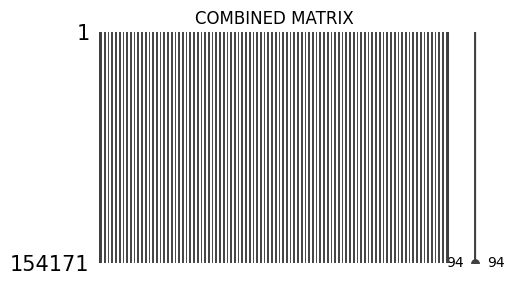

,w1,w2,w3,w4,w5,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility,portfolio_return,sharpe_ratio,time_step
0,0.018280,0.457421,0.339735,0.025705,0.158859,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.003054,0.559795,0
1,0.308815,0.035403,0.020235,0.086907,0.548640,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004147,0.606887,0
2,0.062984,0.253429,0.325864,0.061663,0.296061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.001771,0.603348,0
3,0.137907,0.300914,0.301917,0.230801,0.028461,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000413,0.664390,0
4,0.541262,0.116079,0.061949,0.012493,0.268217,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.005062,0.711601,0
5,0.358276,0.005295,0.227159,0.081295,0.327975,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.002581,0.698030,0
6,0.040227,0.246525,0.102656,0.579531,0.031061,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.004441,0.695801,0
7,0.075562,0.021818,0.468476,0.380103,0.054041,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.000038,0.646816,0
8,0.233522,0.367891,0.175371,0.163280,0.059936,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,0.001828,0.618963,0
9,0.016030,0.373195,0.378387,0.164471,0.067917,-363.036045,0.000659,0.011193,0.914044,-1.1015,...,-0.000977,-0.000112,0.000539,-0.00029,-0.000013,0.0,-0.000289,-0.002142,0.531001,0


In [33]:
# Number of time steps (T) and portfolios (N)
T = len(features)
N = len(portfolio_weights)


### Weights-Features matrix ###
# Create the correct NxT matrix
features_repeated = features.loc[features.index.repeat(N)].reset_index(drop=True) # Repeat each row of features N times
portfolio_repeated = pd.DataFrame(   # Tile (cycle) portfolio weights T times so they align with features
    np.tile(portfolio_weights, (T, 1)),
    columns=columns)
combined_matrix = pd.concat([portfolio_repeated, features_repeated], axis=1) # Combine features and weights side by side


### Adding PTF returns ###
# Recalculate portfolio returns using weights and asset returns
portfolio_returns = np.sum(portfolio_repeated.values * asset_returns.loc[asset_returns.index.repeat(N)].values, axis=1)
portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=['portfolio_return'])  # Convert to DataFrame for consistency
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix
combined_matrix['portfolio_return'] = portfolio_returns_df['portfolio_return'].values # Add portfolio returns to the combined matrix


### Adding Sharpe Ratios ###
combined_matrix['sharpe_ratio'] = rolling_sharpe_ratio(combined_matrix['portfolio_return'], window=30) # Calculate Sharpe ratios for all rows (NxT)
combined_matrix['sharpe_ratio'].fillna(0, inplace=True) # Handle NaNs by replacing with zero 
combined_matrix = combined_matrix[combined_matrix['sharpe_ratio'] != 0].reset_index(drop=True) # Remove rows where Sharpe ratio is NaN or zero


# Group rows by time steps
time_steps = np.arange(len(features))
combined_matrix['time_step'] = np.repeat(time_steps, N)[:len(combined_matrix)] # Assign time step groups, repeated N times (so rows for t1-tN are grouped)


### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

# Now the combined matrix has the following structure: weights, features, portfolio returns, sharpe ratio, time steps (0x50-Nx50)
display(combined_matrix.head(10))



### Prediction Matrix

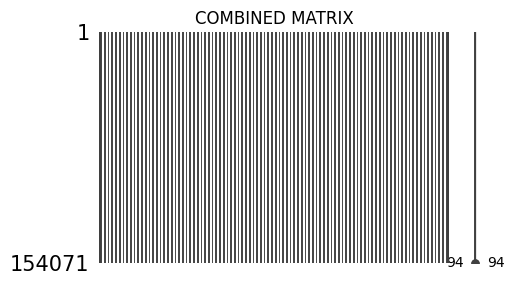

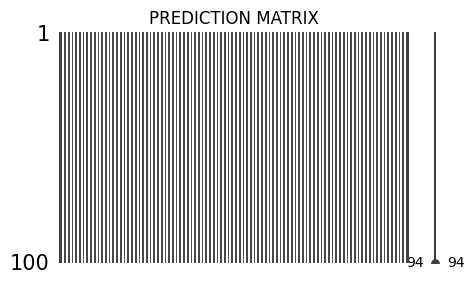

X shape: (154071, 91), y shape: (154071,)
Matching indices: True


In [34]:
# PREDICTION MATRIX
N_P = 2 # how many time step to predict from bottom
predict_matrix = combined_matrix[(-N*N_P):]
combined_matrix = combined_matrix[0:(-N*N_P)]


### Checks ###
missingno.matrix(combined_matrix,figsize=(5,3), fontsize=12)
plt.title("COMBINED MATRIX")
plt.show()

missingno.matrix(predict_matrix,figsize=(5,3), fontsize=12)
plt.title("PREDICTION MATRIX")
plt.show()


# Prepare features (X) and target (y)
X = combined_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])
y = combined_matrix['sharpe_ratio']

# Ensure indices of X and y match
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Matching indices: {(X.index == y.index).all()}")

# Split data into training and testing sets
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]



### Model Training

In [38]:
X_train

,w1,w2,w3,w4,w5,EQ CHINA_roc,EQ CHINA_ema200,EQ CHINA_mad,EQ CHINA_kurtosis,EQ CHINA_skew,...,COPPER,BALTIC DRY IDX,CORP EUR,CORP US,GOVIES SW,GOVIES JP,RF_EU,US_EPS,EU_EPS,Govies Euro Volatility
0,0.018280,0.457421,0.339735,0.025705,0.158859,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.0,-0.000289
1,0.308815,0.035403,0.020235,0.086907,0.548640,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.0,-0.000289
2,0.062984,0.253429,0.325864,0.061663,0.296061,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.0,-0.000289
3,0.137907,0.300914,0.301917,0.230801,0.028461,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.0,-0.000289
4,0.541262,0.116079,0.061949,0.012493,0.268217,-363.036045,0.000659,0.011193,0.914044,-1.101500,...,2.142857,-0.026144,-0.000033,-0.000977,-0.000112,0.000539,-0.000290,-0.000013,0.0,-0.000289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107844,0.297671,0.236215,0.029962,0.323686,0.112465,-162.980502,0.000239,0.005709,-1.376278,0.192215,...,0.007440,-0.019642,-0.000324,-0.001335,-0.004085,0.004124,-0.061125,0.000003,0.0,-0.002064
107845,0.352781,0.484890,0.081962,0.024968,0.055398,-162.980502,0.000239,0.005709,-1.376278,0.192215,...,0.007440,-0.019642,-0.000324,-0.001335,-0.004085,0.004124,-0.061125,0.000003,0.0,-0.002064
107846,0.112444,0.343924,0.397923,0.001408,0.144300,-162.980502,0.000239,0.005709,-1.376278,0.192215,...,0.007440,-0.019642,-0.000324,-0.001335,-0.004085,0.004124,-0.061125,0.000003,0.0,-0.002064
107847,0.128816,0.059885,0.030442,0.098210,0.682646,-162.980502,0.000239,0.005709,-1.376278,0.192215,...,0.007440,-0.019642,-0.000324,-0.001335,-0.004085,0.004124,-0.061125,0.000003,0.0,-0.002064


In [35]:
gbr = GradientBoostingRegressor(random_state=rnd_seed)
rf = RandomForestRegressor(random_state=rnd_seed)
xgb = XGBRegressor(random_state=rnd_seed)

# Random search with time grouping
rf_best_model, rf_best_score, rf_best_params = custom_random_search(rf, rf_params, X_train, y_train)
gbr_best_model, gbr_best_score, gbr_best_params = custom_random_search(gbr, gbr_params, X_train, y_train)
xgb_best_model, xgb_best_score, xgb_best_params = custom_random_search(xgb, xgb_params, X_train, y_train)


print("\nBest Random Forest hyperparameters:", rf_best_params)
print("Regularization params (RF): max_features={}, max_samples={}".format(
    rf_best_params.get('max_features'), rf_best_params.get('max_samples')))

print("\nBest Gradient Boosting hyperparameters:", gbr_best_params)
print("Regularization params (GBR): min_samples_split={}, min_samples_leaf={}".format(
    gbr_best_params.get('min_samples_split'), gbr_best_params.get('min_samples_leaf')))

print("\nBest XGBoost hyperparameters:", xgb_best_params)
print("Regularization params (XGB): min_child_weight={}, gamma={}, reg_alpha={}, reg_lambda={}".format(
    xgb_best_params.get('min_child_weight'), 
    xgb_best_params.get('gamma'),
    xgb_best_params.get('reg_alpha'),
    xgb_best_params.get('reg_lambda')))

_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,"MAE")
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,"MAE")
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,"MAE")


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

valid_assets = [col for col in assets if col in X_pred.columns]
W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()][valid_assets]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()][valid_assets]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()][valid_assets]

print(W_xgb)






Starting Time-Grouped Cross-Validation...


c:\Users\alber\python_projects\IP_AI_project\IP_AI_project\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
def objective(trial, X, y, model_type="rf"):
    if model_type == "rf":
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            max_samples=trial.suggest_float("max_samples", 0.5, 1.0),
            random_state=42
        )
        
    elif model_type == "xgb":
        from xgboost import XGBRegressor
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.7, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
            gamma=trial.suggest_float("gamma", 0, 0.3),
            reg_alpha=trial.suggest_float("reg_alpha", 0, 1.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1, 3.0),
            random_state=42
        )

    elif model_type == "gbr":
        from sklearn.ensemble import GradientBoostingRegressor
        model = GradientBoostingRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.7, 1.0),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            random_state=42
        )

    else:
        raise ValueError("Unknown model type")

    score = time_grouped_cv(model, X, y)
    return score






study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: objective(trial, X_train, y_train, model_type="rf"), n_trials=10)

print("Best RF hyperparameters:", study_rf.best_params)
rf_best_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_best_model.fit(X_train, y_train)

study_gbr = optuna.create_study(direction="maximize")
study_gbr.optimize(lambda trial: objective(trial, X_train, y_train, model_type="gbr"), n_trials=10)

print("Best GBR hyperparameters:", study_gbr.best_params)
gbr_best_model = GradientBoostingRegressor(**study_gbr.best_params, random_state=42)
gbr_best_model.fit(X_train, y_train)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(lambda trial: objective(trial, X_train, y_train, model_type="xgb"), n_trials=10)

print("Best XGB hyperparameters:", study_xgb.best_params)
xgb_best_model = XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_best_model.fit(X_train, y_train)






# Create the best model and fit it
print("Best RF hyperparameters:", study_rf.best_params)
rf_best_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
rf_best_model.fit(X_train, y_train)


_ = evaluate_model("Random Forest", rf_best_model, X_test, y_test,selected_metric_name)
_ = evaluate_model("Gradient Boosting", gbr_best_model, X_test, y_test,selected_metric_name)
_ = evaluate_model("XGBoost", xgb_best_model, X_test, y_test,selected_metric_name)


# prediction
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
X_pred = predict_matrix.drop(columns=['sharpe_ratio', 'portfolio_return', 'time_step'])

yhat_rf = rf_best_model.predict(X_pred)
yhat_gbr = gbr_best_model.predict(X_pred)
yhat_xgb = xgb_best_model.predict(X_pred)

X_pred['yhat_rf'] = yhat_rf
X_pred['yhat_gbr'] = yhat_gbr
X_pred['yhat_xgb'] = yhat_xgb

W_rf = X_pred[X_pred['yhat_rf'] == X_pred['yhat_rf'].max()][valid_assets]
W_gbr = X_pred[X_pred['yhat_gbr'] == X_pred['yhat_gbr'].max()][valid_assets]
W_xgb = X_pred[X_pred['yhat_xgb'] == X_pred['yhat_xgb'].max()][valid_assets]

